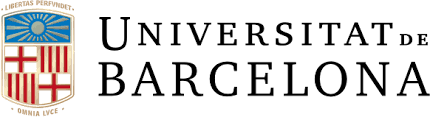

##*Master en Big Data & Data Science*

### **TFM: Clasificación de enfermedades en imágenes médicas utilizando técnicas de Deep Learning**
---

**Alumnos:**
* Santiago Rico Bartolome
* Claudia Alcazar Ureña
* Andres Villa
* Steve Solano Bermudez

**Profesor Tutor:** Ferran Arroyo Vendrell

# Preparacion del Entorno

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import os
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras import utils
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

**Montaje de Google Drive:** Se monta la unidad de Google Drive para acceder a los directorios de entrenamiento y prueba que contienen las imágenes.

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Directorios en local
train_dir = '/content/drive/MyDrive/Training'
test_dir = '/content/drive/MyDrive/Testing'

In [5]:
# Paleta de colores en tonos rojos para la matriz de confusion
cmap = sns.color_palette("Reds")
# Propiedades de las imagenes a usar
batch_size = 32
img_height = 180
img_width = 180

# Preparacion de los Datos

In [6]:
# Creacion del set de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5752 files belonging to 4 classes.
Using 4602 files for training.


In [7]:
# Creacion del set de validacion
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5752 files belonging to 4 classes.
Using 1150 files for validation.


In [13]:
# imprimimos las etiquetas
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


**Visualizacion de algunas imagenes**

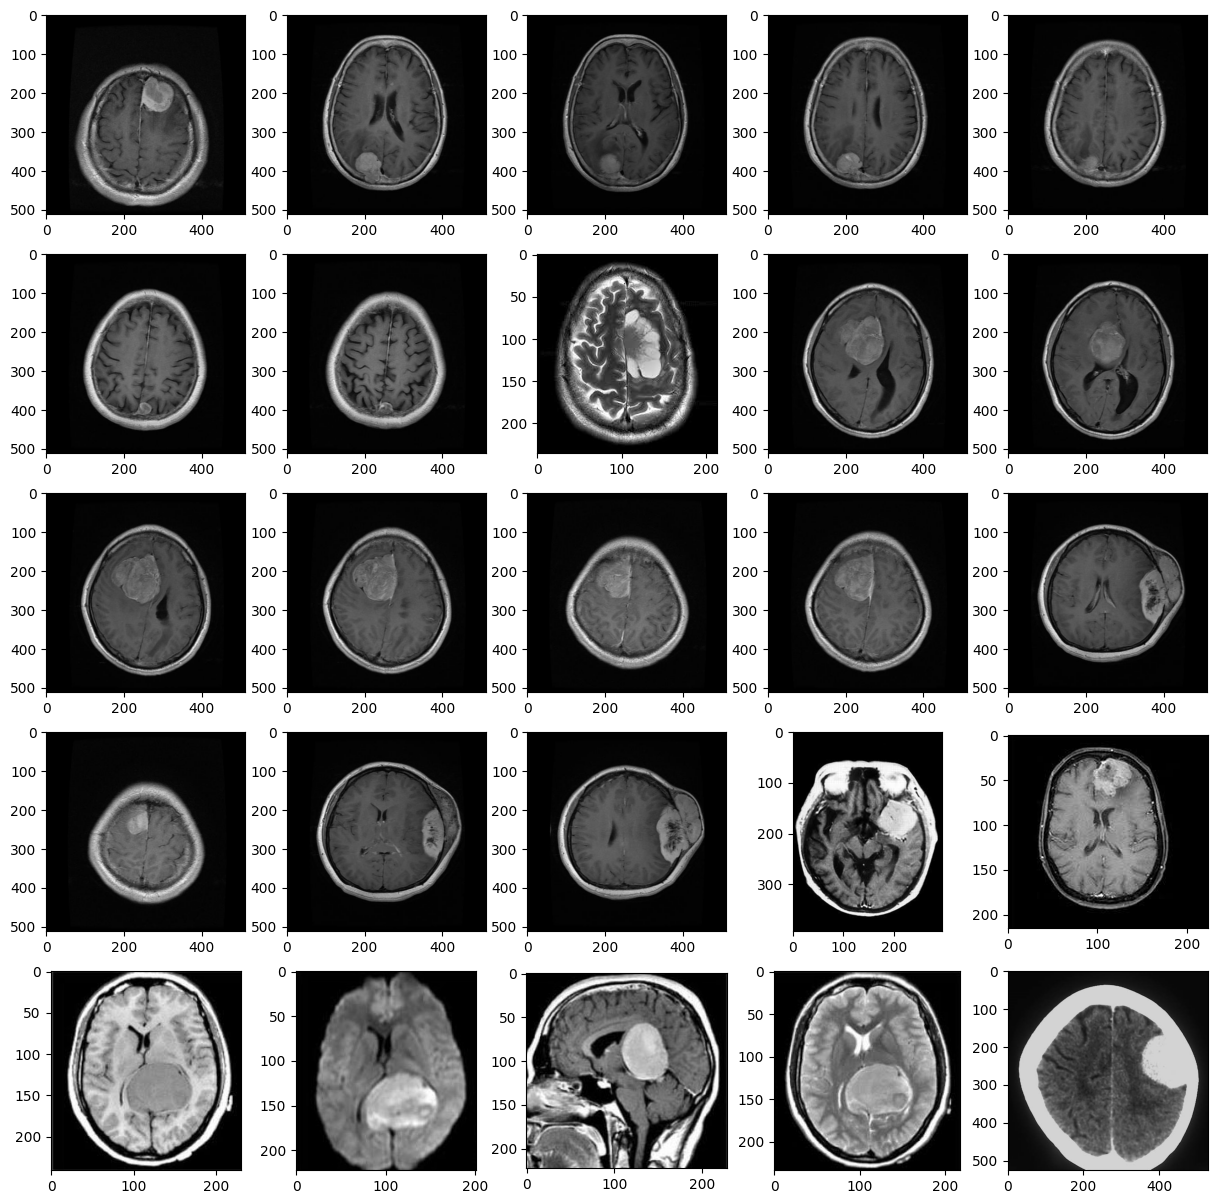

In [8]:
#Mostrar algunas imagenes con pyplot, en este caso: 'Meningiomas'
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

folder = '/content/drive/MyDrive/Training/meningioma'
images = os.listdir(folder)

for i, nameimg in enumerate(images[:25]):
  plt.subplot(5,5,i+1)
  image = mpimg.imread(folder + '/' + nameimg)
  plt.imshow(image)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Uso de la tecnica *Data Augmentation*

In [10]:
# Escalacion de los pixeles en el rango de 0 to 1
normalization_layer = layers.Rescaling(1./255)

In [11]:
# flip, rotate and zoom

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
    ]
)

**Visualizacion de Imagenes despues de Data Augmentation**

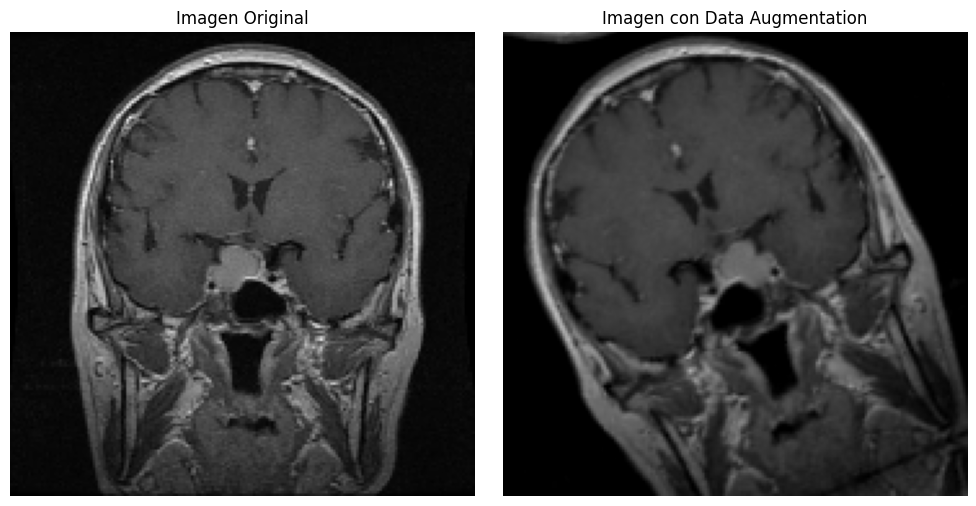

In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.ops.numpy_ops import np_config

# Habilitar el comportamiento de numpy en TensorFlow
np_config.enable_numpy_behavior()

# Obtener una imagen al azar del conjunto de entrenamiento
random_class = random.choice(class_names)
random_class_dir = os.path.join(train_dir, random_class)
random_image_path = random.choice(os.listdir(random_class_dir))
image_path = os.path.join(random_class_dir, random_image_path)

# Cargar la imagen original y redimensionarla
image = load_img(image_path, target_size=(img_height, img_width))
image_array = img_to_array(image)

# Aplicar data augmentation a la imagen
augmented_image_array = data_augmentation(np.expand_dims(image_array, 0))
augmented_image = augmented_image_array[0]

# Normalizar los valores de píxeles al rango [0, 1]
image_array /= 255.0
augmented_image /= 255.0

# Mostrar la imagen original y la imagen con data augmentation
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_array)
axes[0].set_title("Imagen Original")
axes[0].axis("off")
axes[1].imshow(augmented_image)
axes[1].set_title("Imagen con Data Augmentation")
axes[1].axis("off")

plt.tight_layout()
plt.show()





**Resumen de Transformaciones usadas durante Data Augmentation**

In [13]:
print(data_augmentation.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 180, 180, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_contrast (RandomCon  (None, 180, 180, 3)       0         
 trast)                                                          
                                                                 
 random_brightness (RandomB  (None, 180, 180, 3)       0         
 rightness)                                                      
                                                        

## Entrenamiento del Modelo Usando Transfer Learning

In [14]:
# Carga el modelo ResNet50V2 preentrenado sin las capas densas
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

94668760/94668760 [==============================] - 6s 0us/step


In [15]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [16]:
# Mantener las capas de BatchNormalization en modo de inferencia durante fine-tuning
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Llamar al modelo base con training=False para mantener BatchNormalization en modo de inferencia
base_model.trainable = True  # Establecerlo en True antes de fine-tuning

In [17]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.applications import ResNet50V2

# Crear el modelo Sequential final
num_classes = len(class_names)  # 4 clases
model = keras.Sequential([
    data_augmentation,
    normalization_layer,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, name="outputs")
])


In [18]:
# Compilar
from tensorflow.keras.optimizers import Adam

new_learning_rate = 1e-5  # tasa de aprendizaje con un valor muy pequeno
optimizer_with_new_lr = Adam(learning_rate=new_learning_rate)

model.compile(optimizer=optimizer_with_new_lr,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

In [19]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 6, 6, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                      

La implementación de transfer learning en nuestro proyecto ha demostrado ser una estrategia altamente efectiva. Hemos aprovechado modelos de redes neuronales preentrenados, como **ResNet50V2**, que ya han aprendido características valiosas de un conjunto de datos masivo, lo que aceleró significativamente nuestro proceso de entrenamiento y mejoró el rendimiento general del modelo.

Hemos aplicado **fine-tuning** en capas específicas del modelo preentrenado para adaptarlo a nuestra tarea específica. Esto nos ha brindado un mayor control sobre la adaptación del modelo a nuestros datos médicos, manteniendo al mismo tiempo las características aprendidas previamente.

# Early Stopping

Se utiliza la tecnica de Early Stopping

El "early stopping" es una estrategia que permite detener el entrenamiento del modelo antes de completar todas las épocas (iteraciones) previstas si no se observa una mejora en el desempeño del modelo en el conjunto de validación. Esto evita el sobreajuste y ayuda a encontrar el punto óptimo en el que el modelo generaliza mejor

In [20]:
# Model Checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/TFM_CNNv3.2.h5"
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)



In [21]:
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
        checkpoint_cb,
        early_stopping_cb
    ]
)
#  modelo guardado con los mejores pesos (determinados por el "early stopping") se guarda nuevamente en un archivo llamado "TFM_CNNv3.2.h5" en el directorio actual
model.save("TFM_CNNv3.2.h5")

Epoch 1/30
144/144 [==============================] - ETA: 0s - loss: 1.1749 - accuracy: 0.4987

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 [==============================] - 1577s 3s/step - loss: 1.1749 - accuracy: 0.4987 - val_loss: 0.9445 - val_accuracy: 0.6122
Epoch 2/30
144/144 [==============================] - 41s 283ms/step - loss: 0.6314 - accuracy: 0.7751 - val_loss: 0.5998 - val_accuracy: 0.7757
Epoch 3/30
144/144 [==============================] - 43s 300ms/step - loss: 0.4342 - accuracy: 0.8529 - val_loss: 0.4383 - val_accuracy: 0.8313
Epoch 4/30
144/144 [==============================] - 43s 297ms/step - loss: 0.3389 - accuracy: 0.8774 - val_loss: 0.3671 - val_accuracy: 0.8635
Epoch 5/30
144/144 [==============================] - 46s 318ms/step - loss: 0.2881 - accuracy: 0.8970 - val_loss: 0.2882 - val_accuracy: 0.8878
Epoch 6/30
144/144 [==============================] - 47s 329ms/step - loss: 0.2285 - accuracy: 0.9176 - val_loss: 0.2491 - val_accuracy: 0.9070
Epoch 7/30
144/144 [==============================] - 45s 310ms/step - loss: 0.1827 - accuracy: 0.9374 - val_loss: 0.2345 - val_accuracy: 0.91

# Curvas de Rendimiento

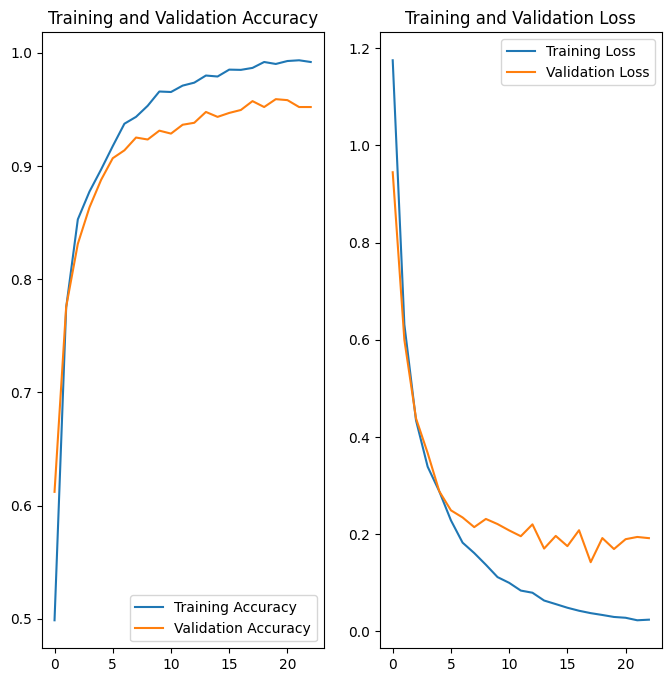

In [22]:
# Grafico de las curva de entrenamiento: train y validation accuracy & loss
epochs = len(history.epoch) # epochs completadas por el early stopping
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Grafica training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Grafica training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluacion del Modelo

In [8]:
# Lectura del Set de Entrenamiento
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

Found 1351 files belonging to 4 classes.


##Predicciones

In [24]:
#Predicciones en el set de Testing
predictions = model.predict(test_ds)
# Se usa tf.nn.softmax ya que se aplico padding en training y al ser un problema multiclase o multinomial
# prediction. Threfore, we used `CategoricalCrossentropy` in model.compile()
scores = tf.nn.softmax(predictions[:])

43/43 [==============================] - 350s 6s/step


In [25]:
for i in range(10):
    print(
        "La imagen corresponde a {} con un {:.2f} porcentage de confianza."
        .format(class_names[np.argmax(scores[i])], 100 * np.max(scores[i]))
    )

La imagen corresponde a notumor con un 99.99 porcentage de confianza.
La imagen corresponde a glioma con un 99.85 porcentage de confianza.
La imagen corresponde a pituitary con un 99.99 porcentage de confianza.
La imagen corresponde a notumor con un 99.89 porcentage de confianza.
La imagen corresponde a pituitary con un 99.96 porcentage de confianza.
La imagen corresponde a notumor con un 99.97 porcentage de confianza.
La imagen corresponde a glioma con un 100.00 porcentage de confianza.
La imagen corresponde a glioma con un 99.08 porcentage de confianza.
La imagen corresponde a meningioma con un 99.89 porcentage de confianza.
La imagen corresponde a glioma con un 100.00 porcentage de confianza.


In [26]:
results = model.evaluate(test_ds)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

43/43 [==============================] - 4s 71ms/step - loss: 0.0769 - accuracy: 0.9785
Test Loss: 0.07687416672706604
Test Accuracy: 0.9785344004631042


In [27]:
# Create two numpy arrays to store labels of test data and prediction
# of respective image
y_test_actual = np.array([])
y_pred_actual = np.array([])

# Iterate over every batch and enter data in created numpy arrays
for x, y in test_ds:
    # Convert label tensor to numpy and concatenate
    y_test = np.array(y)
    y_test_actual = np.concatenate((y_test_actual, y_test))
    # Process prediction score and concatenate result
    predictions = model.predict(x)
    scores = tf.nn.softmax(predictions[:])
    y_pred = np.argmax(scores, axis=1)
    y_pred_actual = np.concatenate((y_pred_actual, y_pred))

1/1 [==============================] - 1s 813ms/step


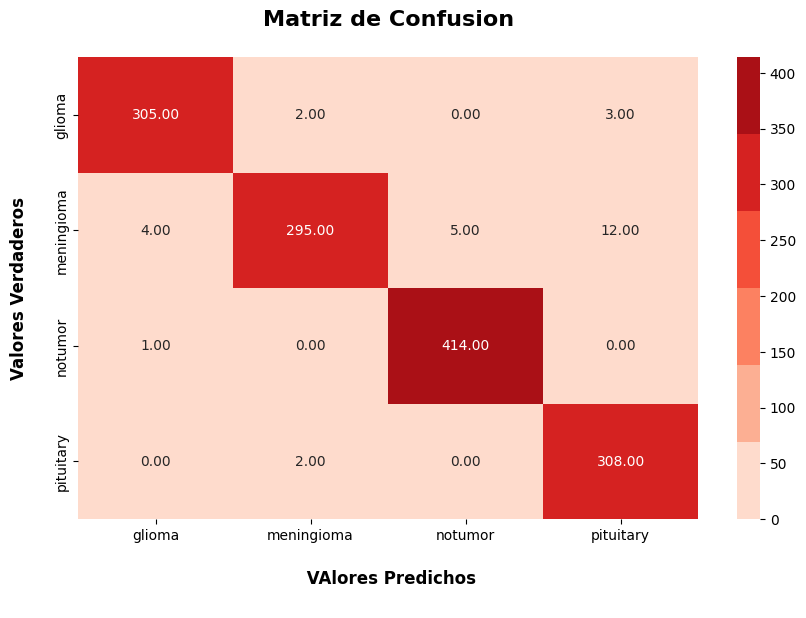

In [28]:
confusion = confusion_matrix(y_test_actual, y_pred_actual)
plt.figure(figsize=(10,6))
fig = sns.heatmap(confusion, annot=True, fmt=".2f",cmap=cmap)

fig.set_title('Matriz de Confusion\n',
              fontdict={
                  "fontsize":16,
                  "fontweight": 'bold'
              })
fig.set_xlabel('\n VAlores Predichos\n',
              fontdict={
                  "fontsize":12,
                  "fontweight": 'semibold'
              })
fig.set_ylabel('Valores Verdaderos\n',
              fontdict={
                  "fontsize":12,
                  "fontweight": 'semibold'
              })
fig.xaxis.set_ticklabels(class_names)
fig.yaxis.set_ticklabels(class_names)
plt.show()

# Informe de Clasificacion

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

# Obtener las etiquetas verdaderas y las predicciones en el conjunto de pruebas
y_true = []
y_pred = []

for x, y in test_ds:
    y_true.extend(y.numpy())
    predictions = model.predict(x)
    y_pred.extend(np.argmax(predictions, axis=1))

# Obtener la información sobre las clases del conjunto de entrenamiento
class_names = class_names

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print("Matriz de Confusion:")
print(cm)

# Obtener el informe de clasificación
report = classification_report(y_true, y_pred, target_names=class_names)
print("Informe de Clasificacion:")
print(report)

1/1 [==============================] - 0s 26ms/step
Matriz de Confusion:
[[305   2   0   3]
 [  4 295   5  12]
 [  1   0 414   0]
 [  0   2   0 308]]
Informe de Clasificacion:
              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       310
  meningioma       0.99      0.93      0.96       316
     notumor       0.99      1.00      0.99       415
   pituitary       0.95      0.99      0.97       310

    accuracy                           0.98      1351
   macro avg       0.98      0.98      0.98      1351
weighted avg       0.98      0.98      0.98      1351



# Pruebas con Bulk Uploading

In [3]:
import tensorflow as tf
import numpy as np
import os
import cv2
from tabulate import tabulate

def get_predictions(test_folder, model):
    img_height, img_width = 180, 180  # Tamaño de las imágenes de entrada del modelo
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Nombres de las clases

    # Función para preprocesar una imagen
    def preprocess_image(image):
        image = cv2.imread(image)  # Leer la imagen
        image = cv2.resize(image, (img_width, img_height))  # Redimensionar la imagen al tamaño de entrada del modelo

        return image

    # Obtener la lista de archivos de imágenes en la carpeta de prueba
    image_files = [os.path.join(test_folder, file) for file in os.listdir(test_folder) if
                   file.endswith((".bmp", ".gif", ".jpeg", ".jpg", ".png"))]

    for image_file in image_files:
        image = preprocess_image(image_file)
        image = np.expand_dims(image, axis=0)  # Agregar una dimensión adicional para el batch
        predictions = model.predict(image)
        scores = tf.nn.softmax(predictions)

        img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        classes = []
        probabilities = []
        for i, class_name in enumerate(class_names):
            class_index = i
            probability = scores[0][class_index] * 100
            classes.append(class_name)
            probabilities.append("%.3f" % probability)

        # Ordenar la tabla por la columna de probabilidades en orden descendente
        sorted_data = sorted(zip(classes, probabilities), key=lambda x: float(x[1]), reverse=True)
        sorted_classes, sorted_probabilities = zip(*sorted_data)

        data = {'Class': sorted_classes, 'Probability (%)': sorted_probabilities}
        table = tabulate(data, headers='keys', tablefmt='fancy_grid')
        print(table)
        print()


1/1 [==============================] - 1s 1s/step


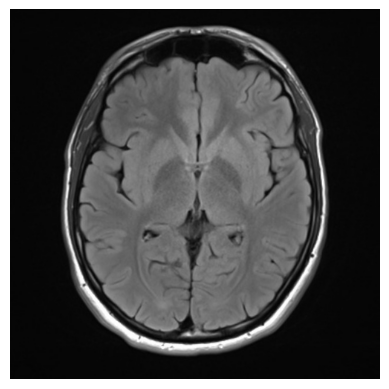

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ notumor    │            99.939 │
├────────────┼───────────────────┤
│ pituitary  │             0.041 │
├────────────┼───────────────────┤
│ meningioma │             0.016 │
├────────────┼───────────────────┤
│ glioma     │             0.004 │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 144ms/step


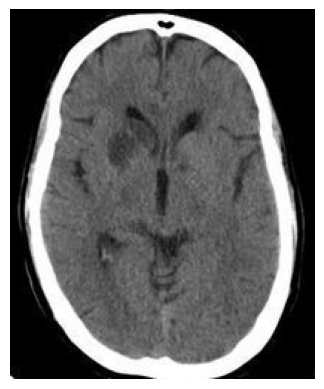

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ notumor    │            99.999 │
├────────────┼───────────────────┤
│ meningioma │             0.001 │
├────────────┼───────────────────┤
│ glioma     │             0     │
├────────────┼───────────────────┤
│ pituitary  │             0     │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 134ms/step


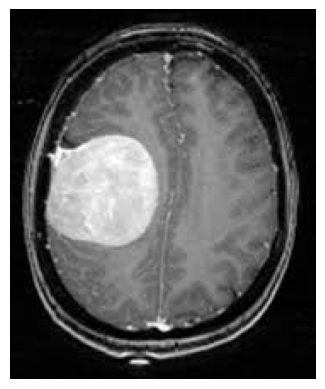

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ meningioma │               100 │
├────────────┼───────────────────┤
│ glioma     │                 0 │
├────────────┼───────────────────┤
│ notumor    │                 0 │
├────────────┼───────────────────┤
│ pituitary  │                 0 │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 125ms/step


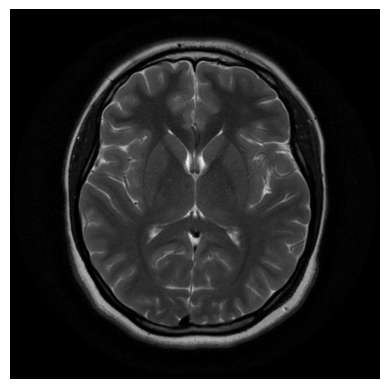

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ notumor    │            99.992 │
├────────────┼───────────────────┤
│ meningioma │             0.006 │
├────────────┼───────────────────┤
│ glioma     │             0.002 │
├────────────┼───────────────────┤
│ pituitary  │             0.001 │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 137ms/step


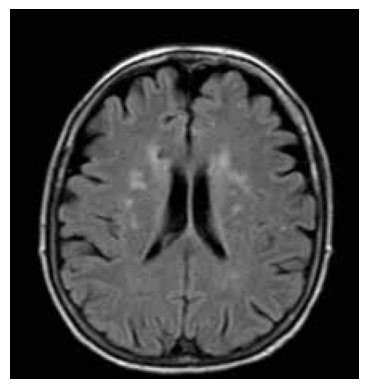

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ notumor    │               100 │
├────────────┼───────────────────┤
│ glioma     │                 0 │
├────────────┼───────────────────┤
│ meningioma │                 0 │
├────────────┼───────────────────┤
│ pituitary  │                 0 │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 136ms/step


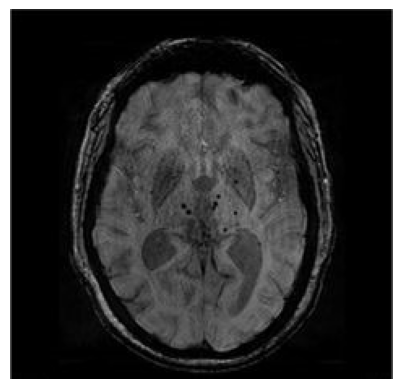

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ notumor    │            99.998 │
├────────────┼───────────────────┤
│ meningioma │             0.001 │
├────────────┼───────────────────┤
│ glioma     │             0     │
├────────────┼───────────────────┤
│ pituitary  │             0     │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 129ms/step


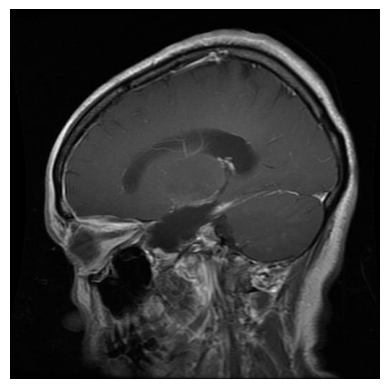

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ glioma     │            99.999 │
├────────────┼───────────────────┤
│ notumor    │             0.001 │
├────────────┼───────────────────┤
│ pituitary  │             0.001 │
├────────────┼───────────────────┤
│ meningioma │             0     │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 325ms/step


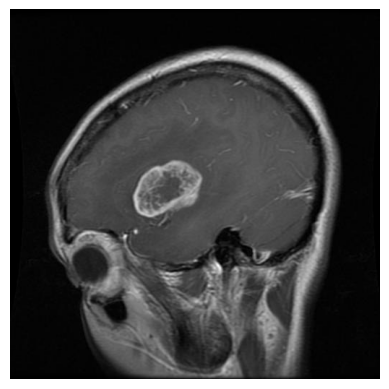

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ glioma     │            99.998 │
├────────────┼───────────────────┤
│ meningioma │             0.001 │
├────────────┼───────────────────┤
│ notumor    │             0.001 │
├────────────┼───────────────────┤
│ pituitary  │             0.001 │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 196ms/step


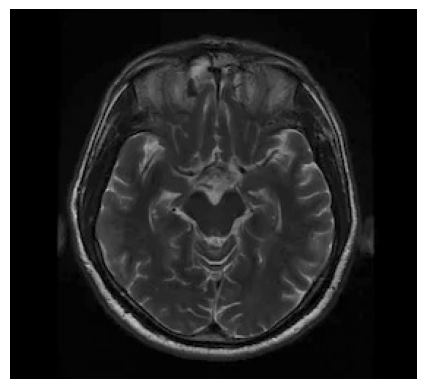

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ notumor    │            99.995 │
├────────────┼───────────────────┤
│ meningioma │             0.003 │
├────────────┼───────────────────┤
│ glioma     │             0.001 │
├────────────┼───────────────────┤
│ pituitary  │             0     │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 124ms/step


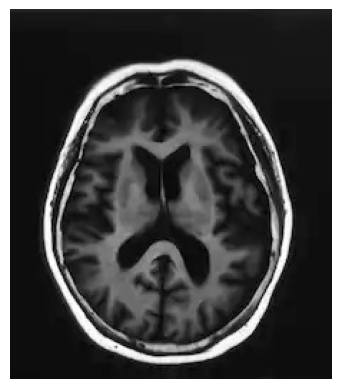

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ notumor    │            99.989 │
├────────────┼───────────────────┤
│ glioma     │             0.008 │
├────────────┼───────────────────┤
│ meningioma │             0.003 │
├────────────┼───────────────────┤
│ pituitary  │             0     │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 134ms/step


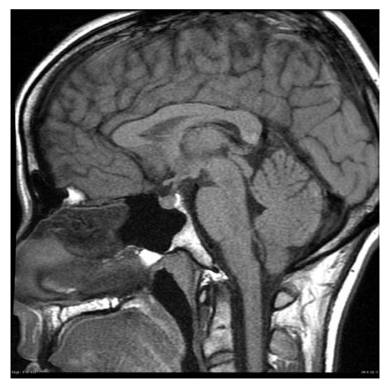

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ pituitary  │            58.807 │
├────────────┼───────────────────┤
│ notumor    │            41.129 │
├────────────┼───────────────────┤
│ meningioma │             0.045 │
├────────────┼───────────────────┤
│ glioma     │             0.02  │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 139ms/step


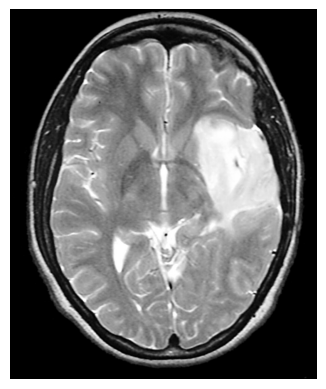

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ notumor    │            99.986 │
├────────────┼───────────────────┤
│ meningioma │             0.012 │
├────────────┼───────────────────┤
│ glioma     │             0.001 │
├────────────┼───────────────────┤
│ pituitary  │             0.001 │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 182ms/step


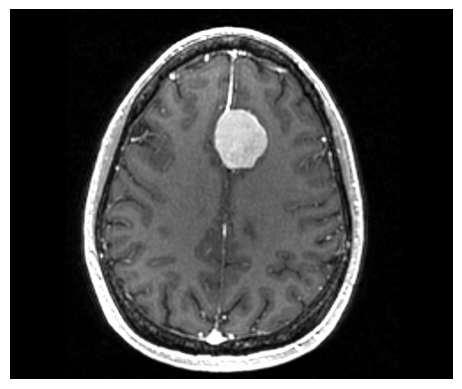

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ meningioma │               100 │
├────────────┼───────────────────┤
│ glioma     │                 0 │
├────────────┼───────────────────┤
│ notumor    │                 0 │
├────────────┼───────────────────┤
│ pituitary  │                 0 │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 227ms/step


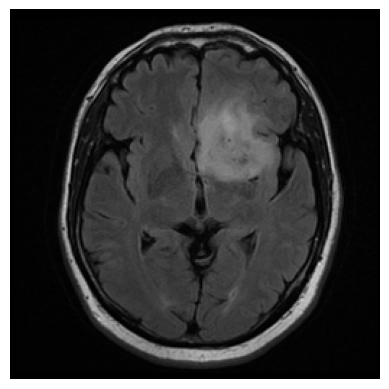

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ pituitary  │            70.346 │
├────────────┼───────────────────┤
│ meningioma │            19.235 │
├────────────┼───────────────────┤
│ notumor    │            10.07  │
├────────────┼───────────────────┤
│ glioma     │             0.349 │
╘════════════╧═══════════════════╛



In [5]:
test_folder = '/content/drive/MyDrive/Patient File'
model = tf.keras.models.load_model('/content/drive/MyDrive/TFM_CNNv3.2.h5')

get_predictions(test_folder, model)

## Area bajo la curva ROC (AUC-ROC)

Found 1351 files belonging to 4 classes.
1/1 [==============================] - 2s 2s/step


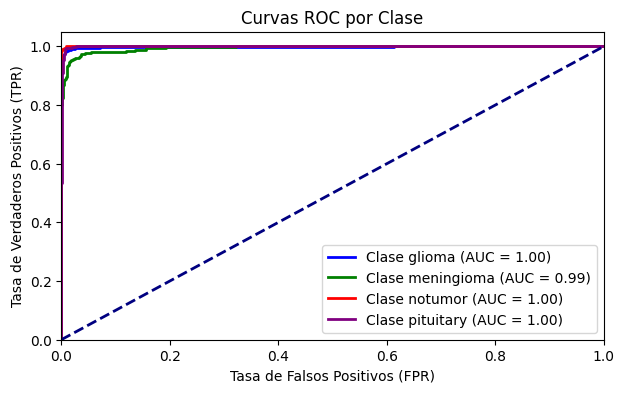

AUC-ROC Promedio: 1.00


In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
import seaborn as sns

# Cargar el modelo desde Google Drive
model_path = '/content/drive/MyDrive/TFM_CNNv3.2.h5'
model = tf.keras.models.load_model(model_path)

# Obtener el conjunto de prueba
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,  # Asegúrate de que no se mezclen las predicciones y etiquetas
    seed=123
)

# Obtener las etiquetas verdaderas y las probabilidades de predicción
y_true = []
y_scores = []

for x, y in test_ds:
    y_true.extend(y.numpy())
    predictions = model.predict(x)
    y_scores.extend(predictions)

# Convierte y_scores a un arreglo numpy
y_scores = np.array(y_scores)

# Calcula el AUC-ROC para cada clase
n_classes = len(class_names)
roc_auc_per_class = []

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true, y_scores[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    roc_auc_per_class.append(roc_auc)

# Visualiza las curvas ROC y muestra el AUC-ROC para cada clase
plt.figure(figsize=(7, 4))
colors = ['blue', 'green', 'red', 'purple']  # Colores para las curvas ROC, una para cada clase

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true, y_scores[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Clase {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Muestra el AUC-ROC promedio
average_roc_auc = sum(roc_auc_per_class) / n_classes
print(f'AUC-ROC Promedio: {average_roc_auc:.2f}')


Basándonos en el informe de clasificación, la matriz de confusión y la curva AUC-ROC que hemos obtenido, podemos concluir lo siguiente:

El rendimiento de nuestro modelo de clasificación de imágenes médicas es elevado. Esto se refleja en los altos valores de precisión, recall y F1-score para todas las clases, así como en el AUC-ROC promedio de casi un 1.00. Nuestro modelo es capaz de distinguir con precisión entre las clases en nuestro conjunto de prueba.

La alta precisión y recall indican que nuestro modelo hace un buen trabajo tanto en la identificación de muestras positivas como en la minimización de falsos positivos, lo cual es esencial en aplicaciones médicas donde queremos evitar errores.

No parece haber un desequilibrio significativo entre las clases, ya que las métricas de precision y recall son altas para todas ellas.

Nuestra matriz de confusión muestra que la mayoría de las predicciones son correctas, con valores diagonales altos. Los valores fuera de la diagonal principal son bajos, lo que indica que los errores son mínimos.

La curva AUC-ROC, con un AUC promedio de basicamente 1.00, indica que nuestro modelo puede discriminar perfectamente entre las clases. Esto refuerza la confianza en nuestras predicciones precisas.

En general, estos resultados sugieren que nuestro modelo es altamente efectivo en la tarea de clasificación de imágenes médicas y tiene un excelente poder discriminativo entre las clases.